In [1]:
import pandas as  pd
import numpy as np
# model metrics 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
# import models
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
# import Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('bank.csv')
print(df.info())
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [3]:
df.rename(columns = {'poutcome':'p_outcome','pdays':'p_days','y':'Deposit'},inplace=True)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,p_days,previous,p_outcome,Deposit
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [4]:
# Removing Outliers

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] 
                                                        < fence_high)]
    return df_out

remove_outlier(df,'age')
remove_outlier(df,'balance')
remove_outlier(df,'day')
remove_outlier(df,'duration')
remove_outlier(df,'campaign')
remove_outlier(df,'p_days')
remove_outlier(df,'previous')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,p_days,previous,p_outcome,Deposit


In [5]:
df.describe()

,age,balance,day,duration,campaign,p_days,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


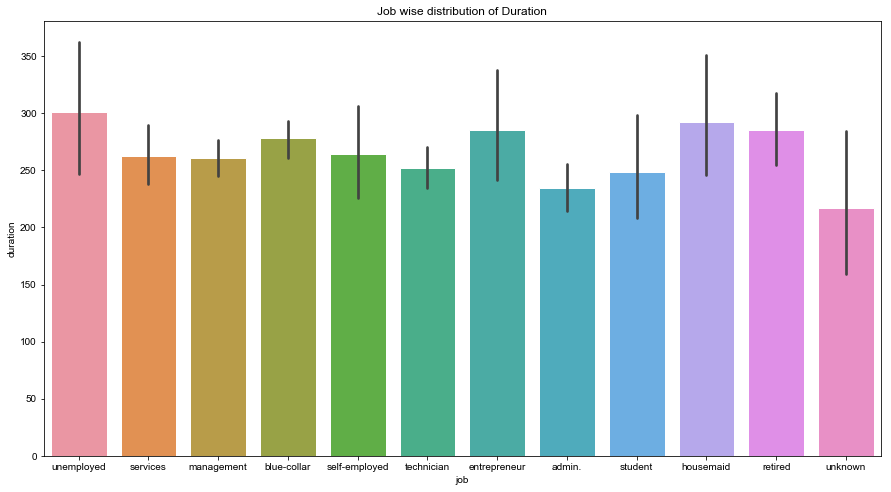

In [6]:

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')

# Bar plot for Job wise distribution of Duration

sns.barplot(x='job',y='duration',data=df[['job','duration']],ax=ax)
ax.set_title('Job wise distribution of Duration')
plt.show()

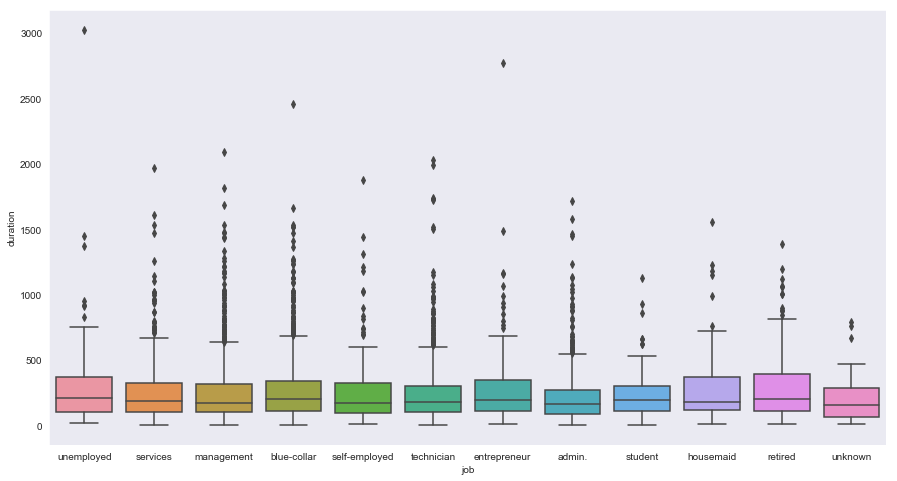

In [7]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
sns.boxplot(x="job", y="duration", data=df)
plt.show()

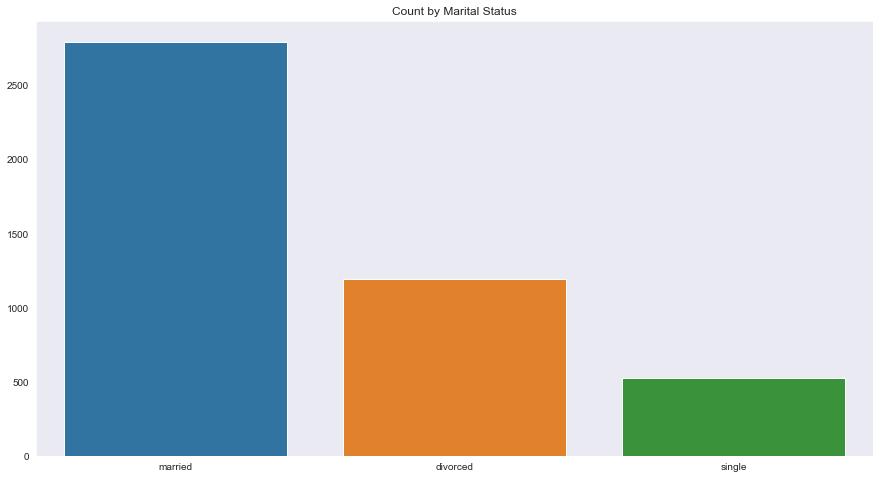

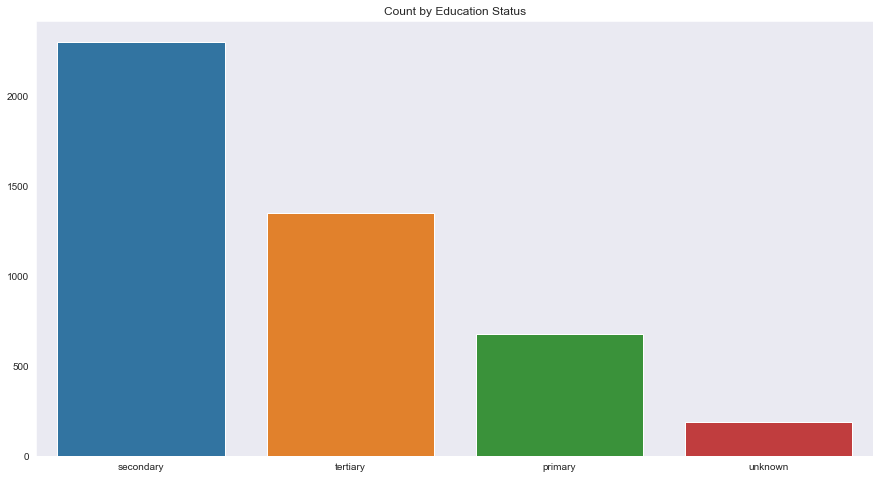

In [8]:
##Ploting the count of marital and education
values = df['marital'].value_counts().tolist()
labels = ['married', 'divorced', 'single']
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
sns.barplot(x=labels, y=values, data=df)
plt.title("Count by Marital Status")
plt.show()

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
val = df['education'].value_counts().tolist()
lab = ['secondary', 'tertiary', 'primary', 'unknown']
sns.barplot(x=lab, y=val, data=df)
plt.title("Count by Education Status")
plt.show()

In [9]:
X = df.iloc[:, 0:16]
Y = df.iloc[:, 16]

In [10]:
#Splitting the catagorical variable to 0s and 1s using LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

LabelEncoder().fit_transform(['no','yes'])
housing = LabelEncoder().fit_transform(X['housing'])
loan = LabelEncoder().fit_transform(X['loan'])
deposit = LabelEncoder().fit_transform(Y)
job = LabelEncoder().fit_transform(X['job'])
marital = LabelEncoder().fit_transform(X['marital'])
education = LabelEncoder().fit_transform(X['education'])
poutcome = LabelEncoder().fit_transform(X['p_outcome'])

In [11]:
X['housing'] = housing
X['loan']= loan
X['job'] = job
X['marital']=marital
X['education']=education
X['p_outcome']=poutcome
Y=deposit
del X['month']
del X['day']
del X['contact']
del X['default']

In [12]:
print(X.shape,Y.shape)

(4521, 12) (4521,)


In [13]:

from sklearn.compose import ColumnTransformer
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(),
                                        [1,2,3,11])], 
                                      remainder='passthrough')
X=np.array(columnTransformer.fit_transform(X))

In [14]:
X.shape

(4521, 31)

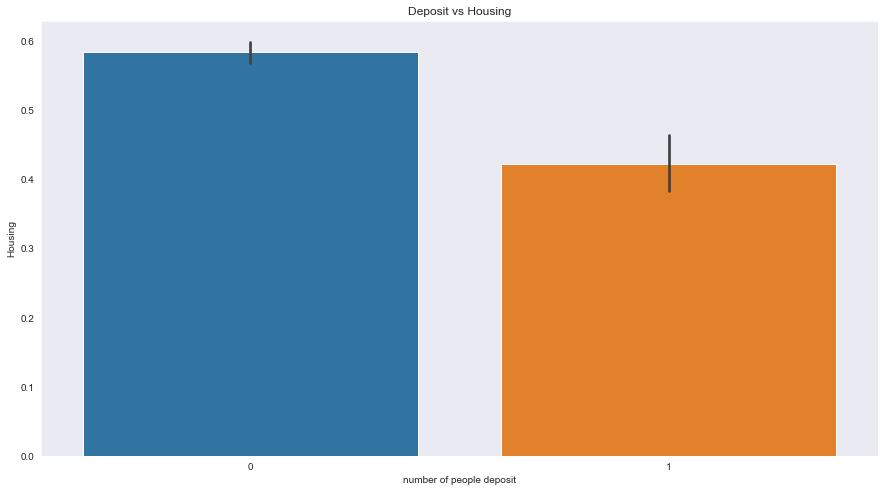

In [15]:
## PLoting housing vs deposit shows us a clear view how many people have deposited interms of hosuing 
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
sns.barplot(x=deposit, y=housing, data= df)
plt.xlabel("number of people deposit")
plt.ylabel("Housing")
plt.title("Deposit vs Housing")
plt.show()

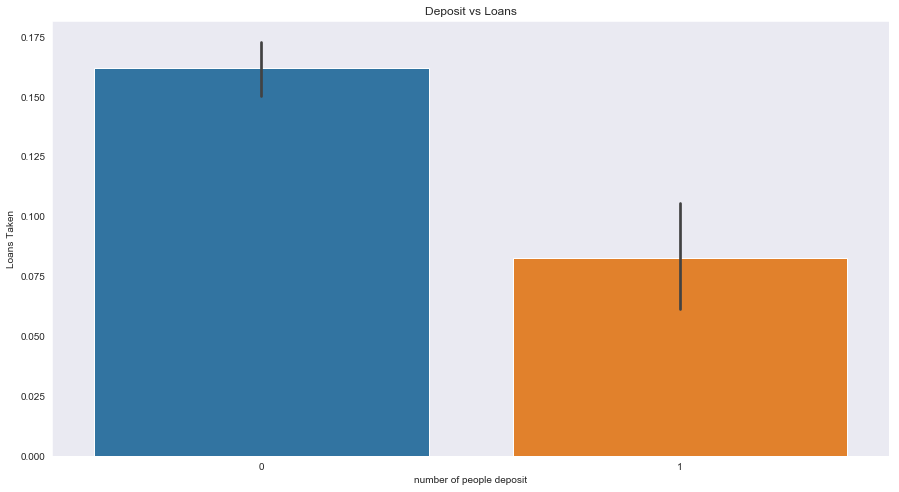

In [16]:
### This plot bet loan vs deposit has shown 83% has 
# not deposited and 17% remaining have deposits 
# which gives a weight to output.

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
sns.barplot(x=deposit, y=loan, data= df)
plt.xlabel("number of people deposit")
plt.ylabel("Loans Taken")
plt.title("Deposit vs Loans")
plt.show()

In [17]:
## spliting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                    test_size = 0.2,
                                                    random_state = 123)
## Feature scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [23]:
# train the model and use it to predict the label for unseen data
def fit_ml_algo(algo, X_train, y_train, X_test, y_test):
    
    model = algo.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = round(accuracy_score(y_pred, y_test) * 100, 2)
    cf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = precision_score(y_pred, y_test)
    f1 = f1_score(y_test, y_pred)
     
    return acc, cf_matrix, precision, recall, f1, model

Testing Accuracy:  91.6 %
Training Accuracy : 89.85 %
Precision:  0.7058823529411765
Recall:  0.3711340206185567
F1 Score:  0.48648648648648646


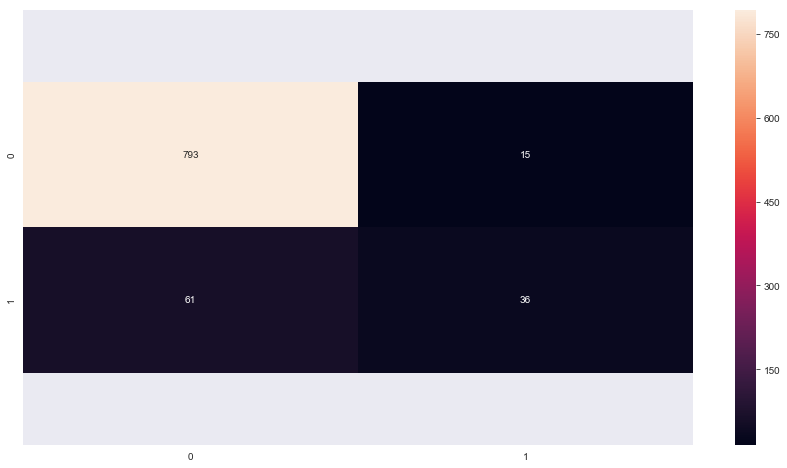

In [27]:
# LOGISTIC REGRESSION

acc, cf_matrix, precision, recall, f1, model = fit_ml_algo(
    LogisticRegression(), X_train, y_train, X_test, y_test)
y_pred_train = model.predict(X_train)
acc_train = round(accuracy_score(y_pred_train, y_train) * 100, 2)
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
ax = sns.heatmap(cf_matrix, annot=True, fmt='g') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print("Testing Accuracy: ", acc,'%')
print("Training Accuracy :",acc_train,'%')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)


Testing Accuracy:  90.39 %
Training Accuracy : 100.0 %
Precision:  0.6388888888888888
Recall:  0.23711340206185566
F1 Score:  0.3458646616541353


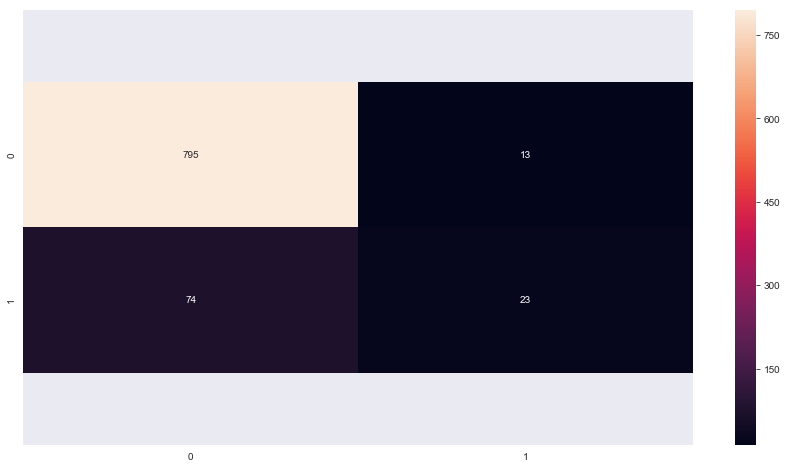

In [28]:
# RANDOM FOREST CLASSIFIER

acc, cf_matrix, precision, recall, f1, model = fit_ml_algo(
    RandomForestClassifier(), X_train, y_train, X_test, y_test)
y_pred_train = model.predict(X_train)
acc_train = round(accuracy_score(y_pred_train, y_train) * 100, 2)
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
ax = sns.heatmap(cf_matrix, annot=True, fmt='g') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print("Testing Accuracy: ", acc,'%')
print("Training Accuracy :",acc_train,'%')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Testing Accuracy:  91.38 %
Training Accuracy : 89.57 %
Precision:  0.7209302325581395
Recall:  0.31958762886597936
F1 Score:  0.4428571428571428


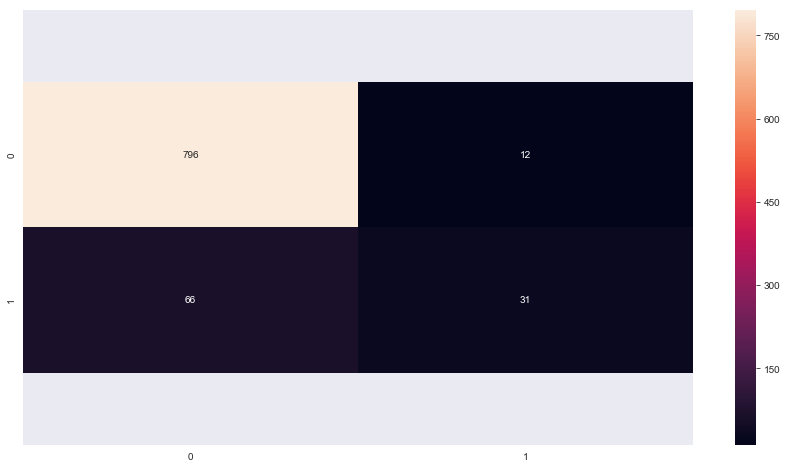

In [29]:
# SUPPORT VECTOR MACHINE

acc, cf_matrix, precision, recall, f1, model = fit_ml_algo(LinearSVC(),
                                    X_train, y_train, X_test, y_test)
y_pred_train = model.predict(X_train)
acc_train = round(accuracy_score(y_pred_train, y_train) * 100, 2)
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
ax = sns.heatmap(cf_matrix, annot=True, fmt='g') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print("Testing Accuracy: ", acc,'%')
print("Training Accuracy :",acc_train,'%')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Testing Accuracy:  90.94 %
Training Accuracy : 92.89 %
Precision:  0.6666666666666666
Recall:  0.30927835051546393
F1 Score:  0.4225352112676056


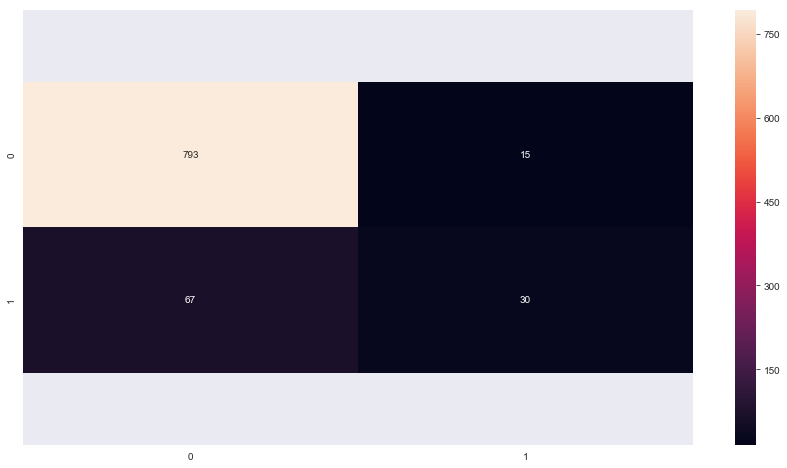

In [30]:
# GRADIENT BOOSTING CLASSIFIER

acc, cf_matrix, precision, recall, f1, model = fit_ml_algo(
    GradientBoostingClassifier(), X_train, y_train, X_test, y_test)
y_pred_train = model.predict(X_train)
acc_train = round(accuracy_score(y_pred_train, y_train) * 100, 2)
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
ax = sns.heatmap(cf_matrix, annot=True, fmt='g') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print("Testing Accuracy: ", acc,'%')
print("Training Accuracy :",acc_train,'%')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Testing Accuracy:  91.6 %
Training Accuracy : 89.96 %
Precision:  0.723404255319149
Recall:  0.35051546391752575
F1 Score:  0.47222222222222215


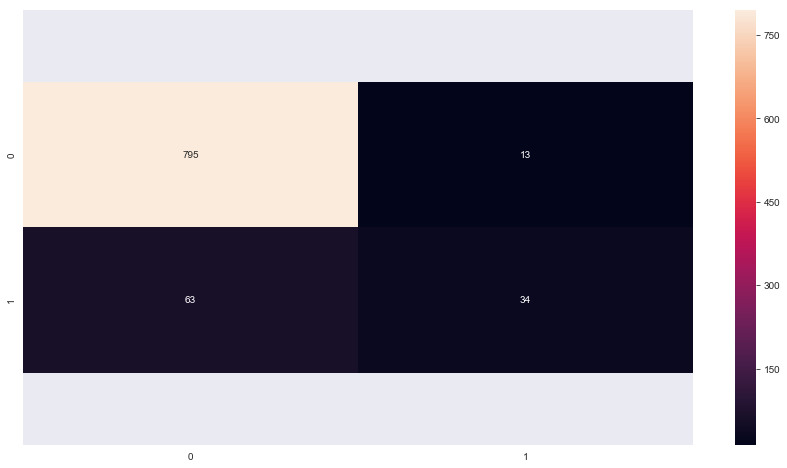

In [31]:
# ADABOOST CLASSIFIER

acc, cf_matrix, precision, recall, f1, model = fit_ml_algo(
    AdaBoostClassifier(), X_train, y_train, X_test, y_test)
y_pred_train = model.predict(X_train)
acc_train = round(accuracy_score(y_pred_train, y_train) * 100, 2)
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('dark')
ax = sns.heatmap(cf_matrix, annot=True, fmt='g') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print("Testing Accuracy: ", acc,'%')
print("Training Accuracy :",acc_train,'%')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

